In [1]:
!pip install opencv-python

   ---------------------------------------- 0.0/39.5 MB ? eta -:--:--
    --------------------------------------- 0.5/39.5 MB 3.4 MB/s eta 0:00:12
   - -------------------------------------- 1.3/39.5 MB 3.4 MB/s eta 0:00:12
   - -------------------------------------- 1.8/39.5 MB 3.2 MB/s eta 0:00:12
   -- ------------------------------------- 2.6/39.5 MB 3.3 MB/s eta 0:00:12
   --- ------------------------------------ 3.1/39.5 MB 3.2 MB/s eta 0:00:12
   --- ------------------------------------ 3.9/39.5 MB 3.3 MB/s eta 0:00:11
   ---- ----------------------------------- 4.5/39.5 MB 3.3 MB/s eta 0:00:11
   ----- ---------------------------------- 5.2/39.5 MB 3.2 MB/s eta 0:00:11
   ------ --------------------------------- 6.0/39.5 MB 3.2 MB/s eta 0:00:11
   ------ --------------------------------- 6.8/39.5 MB 3.3 MB/s eta 0:00:11
   ------- -------------------------------- 7.3/39.5 MB 3.2 MB/s eta 0:00:10
   -------- ------------------------------- 8.1/39.5 MB 3.2 MB/s eta 0:00:10
   ---

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [15]:
from glob import glob
from PIL import Image
from numpy import asarray

In [17]:
dirct = r"D:\IAT\Brain-Tumor-Detection-main"

In [19]:
import os
path = os.listdir(dirct+'/Brain_Tumor_Data')
classes = {'no_tumor':0, 'pituitary_tumor':1}

In [21]:
no_tumor_frompath= dirct+'/Brain_Tumor_Data/Training/no_tumor'
no_tumor_topath = dirct+'/Brain_Tumor_Data/Agumented_Data/Training/no_tumor/'
no_tumor_images=glob(no_tumor_frompath+'/*')
c=0
for path in no_tumor_images:
  img=Image.open(path)
  img=img.resize((224,224))
  img.save(no_tumor_topath+str(c)+'.jpg')
  c+=1
  mirimg=img.transpose(Image.FLIP_LEFT_RIGHT)
  mirimg.save(no_tumor_topath+str(c)+'.jpg')
  c+=1
  rotimg=img.rotate(90,Image.NEAREST, expand = 1)
  rotimg.save(no_tumor_topath+str(c)+'.jpg')
  c+=1
  mirrotimg=rotimg.transpose(Image.FLIP_LEFT_RIGHT)
  mirrotimg.save(no_tumor_topath+str(c)+'.jpg')
  c+=1

In [22]:
frompath = dirct+'Brain_Tumor_Data/Training/pituitary_tumor'
topath = dirct+'Brain_Tumor_Data/Agumented_Data/Training/pituitary_tumor/'
images=glob(frompath+'/*')
c=0
for path in images:
  img=Image.open(path)
  img=img.resize((224,224))
  img.save(topath+str(c)+'.jpg')
  c+=1
  mirimg=img.transpose(Image.FLIP_LEFT_RIGHT)
  mirimg.save(topath+str(c)+'.jpg')
  c+=1
  rotimg=img.rotate(90,Image.NEAREST, expand = 1)
  rotimg.save(topath+str(c)+'.jpg')
  c+=1
  mirrotimg=rotimg.transpose(Image.FLIP_LEFT_RIGHT)
  mirrotimg.save(topath+str(c)+'.jpg')
  c+=1

In [25]:
import cv2
X=[]
Y=[]
for cls in classes:
  pth = dirct+'/Brain_Tumor_Data/Agumented_Data/Training/'+cls
  for j in os.listdir(pth):
    img = cv2.imread(pth+'/'+j)   
    # img = cv2.resize(img,dsize=(224,224))
    X.append(img)
    Y.append(classes[cls])

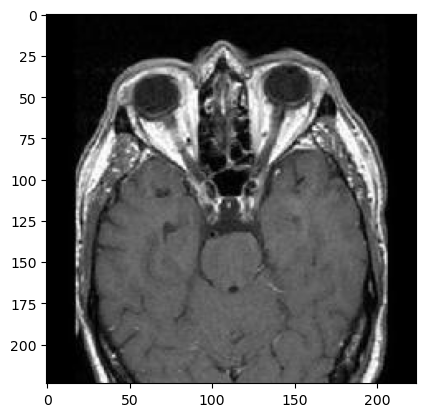

In [27]:
plt.imshow(X[0],cmap='gray')

In [29]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,random_state=10,test_size=0.20)
print ("Shape of an image in x_train: ", x_train[0].shape)
print ("Shape of an image in x_test: ", x_test[0].shape)

Shape of an image in x_train:  (224, 224, 3)
Shape of an image in x_test:  (224, 224, 3)


In [31]:
from sklearn import preprocessing
import tensorflow as tf
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
x_train = np.array(x_train)
y_test = np.array(y_test)
x_test = np.array(x_test) 
print("x_train Shape: ", x_train.shape) 
print("x_test Shape: ", x_test.shape)
print("y_train Shape: ", y_train.shape) 
print("y_test Shape: ", y_test.shape)

x_train Shape:  (3910, 224, 224, 3)
x_test Shape:  (978, 224, 224, 3)
y_train Shape:  (3910, 2)
y_test Shape:  (978, 2)


In [33]:
from keras.applications import vgg16

img_rows,img_cols=224,224

vgg=vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows,img_cols,3))

In [35]:
for layer in vgg.layers:
  layer.trainable=False


In [37]:
from tensorflow.keras.layers import GlobalAveragePooling2D
def lw(bottom_model,num_classes):
  top_model=bottom_model.output
  top_model=GlobalAveragePooling2D()(top_model)
  top_model=Dense(1024,activation='relu')(top_model)
  top_model=Dense(1024,activation='relu')(top_model)
  top_model=Dense(512,activation='relu')(top_model)
  top_model=Dense(num_classes,activation='softmax')(top_model)
  return top_model

In [39]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,GlobalAveragePooling2D
from keras.layers import Conv2D,MaxPooling2D,ZeroPadding2D
from keras.models import Model

In [41]:
import tempfile

def make_keras_picklable():
    def __getstate__(self):
        model_str = ""
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            save_model(self, fd.name, overwrite=True)
            model_str = fd.read()
        d = {'model_str': model_str}
        return d

    def __setstate__(self, state):
        with tempfile.NamedTemporaryFile(suffix='.hdf5', delete=True) as fd:
            fd.write(state['model_str'])
            fd.flush()
            model = load_model(fd.name)
        self.__dict__ = model.__dict__


    cls = Model
    cls.__getstate__ = __getstate__
    cls.__setstate__ = __setstate__


In [43]:
make_keras_picklable()

In [45]:
num_classes=2
FC_Head=lw(vgg,num_classes)
model=Model(inputs=vgg.input,outputs=FC_Head)
print(model.summary())

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         525,3

 Total params: 16,815,426 (64.15 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

None


In [47]:
from tensorflow.keras.models import Model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [43]:
history=model.fit(x_train,y_train,epochs=5,validation_data=(x_test,y_test),verbose=1,initial_epoch=0)

Epoch 1/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 764s 6s/step - accuracy: 0.8458 - loss: 1.4234 - val_accuracy: 0.9806 - val_loss: 0.0638
Epoch 2/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 772s 6s/step - accuracy: 0.9886 - loss: 0.0380 - val_accuracy: 0.9816 - val_loss: 0.0631
Epoch 3/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 779s 6s/step - accuracy: 0.9864 - loss: 0.0466 - val_accuracy: 0.9816 - val_loss: 0.0622
Epoch 4/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 662s 5s/step - accuracy: 0.9890 - loss: 0.0342 - val_accuracy: 0.9908 - val_loss: 0.0291
Epoch 5/5
123/123 ━━━━━━━━━━━━━━━━━━━━ 6016s 49s/step - accuracy: 0.9975 - loss: 0.0081 - val_accuracy: 0.9847 - val_loss: 0.0453


In [49]:
import pickle
filename= 'brain_tumor_model.pkl'

In [51]:

pickle.dump(model,open(filename,'wb'))

In [57]:
load_model = pickle.load(open(filename,'rb'))
#load_model.predict(x_test)

In [59]:
from tensorflow.keras.models import model_from_json

# Serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("model.weights.h5")  # Use `.weights.h5` as the file extension

In [61]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")

In [71]:
value = loaded_model.predict(x_test)

31/31 ━━━━━━━━━━━━━━━━━━━━ 142s 5s/step


In [65]:
dec= {0: 'No Tumor', 1:'Positive Tumor'}

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 667ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 838ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


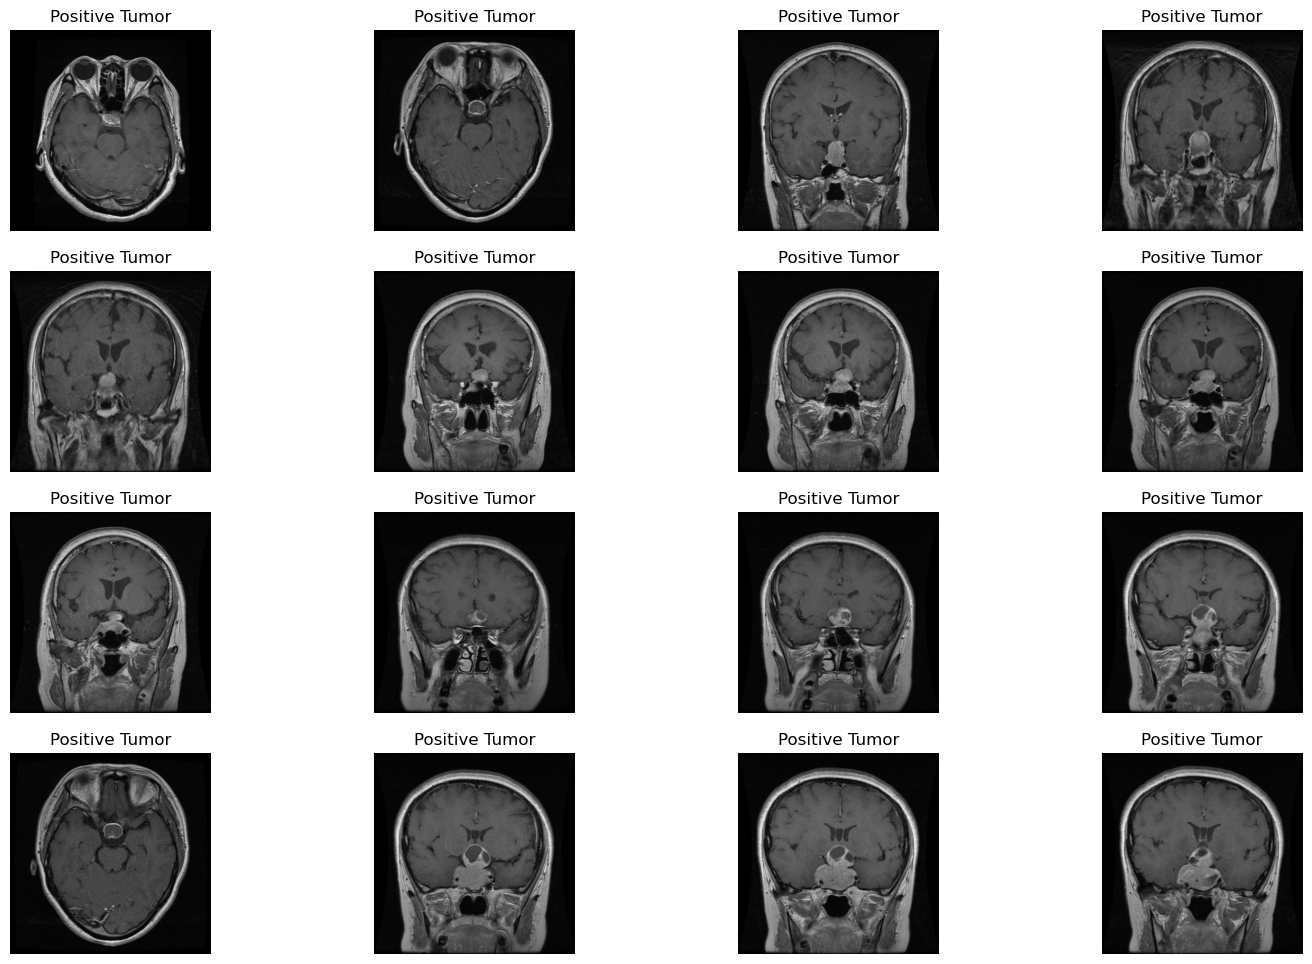

In [67]:
plt.figure(figsize=(18,12))
p = os.listdir('D:/IAT/Brain-Tumor-Detection-main/Brain_Tumor_Data/Training/pituitary_tumor')

c = 1
predict_img = []
for i in os.listdir('D:/IAT/Brain-Tumor-Detection-main/Brain_Tumor_Data/Training/pituitary_tumor')[:16]:
    plt.subplot(4, 4, c)

    img = cv2.imread('D:/IAT/Brain-Tumor-Detection-main/Brain_Tumor_Data/Training/pituitary_tumor/' + i)
    img1 = cv2.resize(img, (224, 224))
    predict_img.append(img1)
    p = load_model.predict(np.array(predict_img))
    result = np.argmax(p, axis=1)
    plt.title(dec[result[c-1]])
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    c += 1

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 669ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 521ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 761ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 902ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


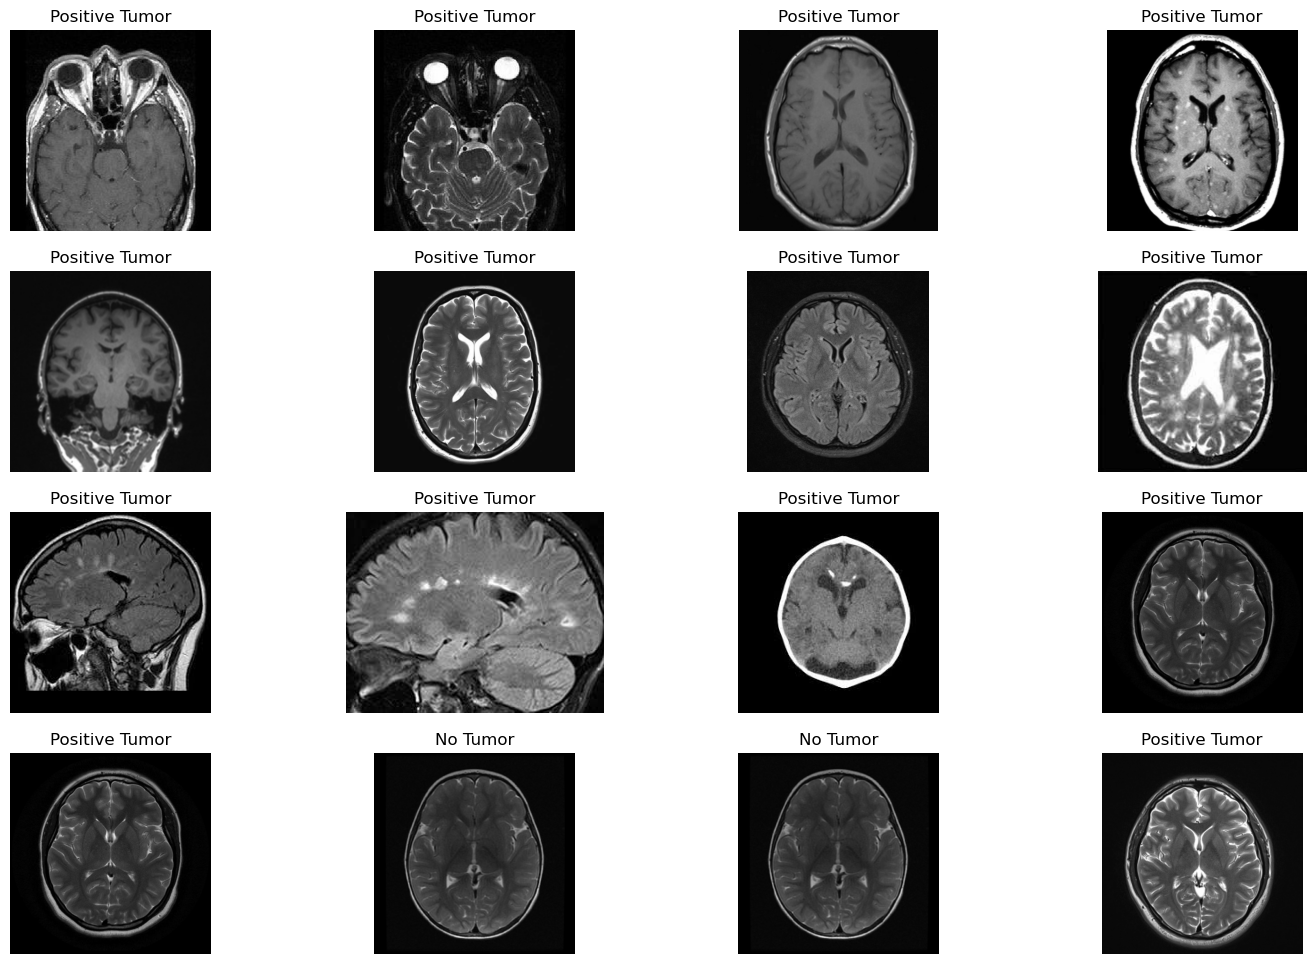

In [69]:
plt.figure(figsize=(18,12))
p=os.listdir('D:/IAT/Brain-Tumor-Detection-main/Brain_Tumor_Data/Training/no_tumor')
c=1
predict_img=[]
for i in os.listdir('D:/IAT/Brain-Tumor-Detection-main/Brain_Tumor_Data/Training/no_tumor')[:16]:
  plt.subplot(4,4,c)

  img=cv2.imread('D:/IAT/Brain-Tumor-Detection-main/Brain_Tumor_Data/Training/no_tumor/'+i)
  img1 = cv2.resize(img,(224,224))
  predict_img.append(img1)
  p= model.predict(np.array(predict_img))
  result = np.argmax(p, axis =1)
  plt.title(dec[result[c-1]])
  plt.imshow(img,cmap='gray')
  plt.axis('off')
  c+=1